# 2) PMI (Pointwise Mutual Information) - Tolstoy Project

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

**Project:** *War and Peace* and *Anna Karenina* by Leo Tolstoy.

Overview:
- Compute pointwise mutual information (PMI) for bigrams in *War and Peace* and *Anna Karenina*.
- Use PMI to find word pairs that co-occur more often than expected by chance.

Learning objectives:
- Estimate unigram and bigram probabilities from counts and compute PMI.
- Apply frequency thresholds to reduce spurious high-PMI rare pairs.
- Visualize and export the top PMI bigrams as CSV and PNG for reporting.

## 0. Setup & Configuration

- Paths for the two books are filled in automatically below.
- Stopwords are disabled by default (`use_stopwords: False`).

In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "",  # <-- Will be filled dynamically
    "book2_path": "",  # <-- Will be filled dynamically
    "language": "en",
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


In [2]:
# ===== Dynamic Path Finding (from friend's notebook) =====

# Automatically find project root and data folder
nb_path = Path.cwd()
project_root = nb_path
for _ in range(4):
    if (project_root / "data").exists():
        break
    project_root = project_root.parent

data_dir = project_root / "data"
results_dir = project_root / "results"
results_dir.mkdir(exist_ok=True)

def find_book(patterns):
    """Finds the first file in data_dir matching a list of patterns."""
    for pat in patterns:
        matches = list(data_dir.rglob(pat))
        if matches:
            return matches[0]
    return None

# Use the same file patterns as your friend's notebook
patterns_war = ["*War*Peace*.txt", "*War_and_Peace*.txt"]
patterns_anna = ["*Anna*Karenin*.txt", "*Anna_Karenina*.txt"]

file_war = find_book(patterns_war)
file_anna = find_book(patterns_anna)

if file_war is None or file_anna is None:
    print("Warning: Could not find one or both text files in ../data/")
    print("Please add 'War and Peace' and 'Anna Karenina' .txt files to your data folder.")
else:
    # Update the CONFIG dictionary with the found paths
    CONFIG["book1_path"] = str(file_war)
    CONFIG["book2_path"] = str(file_anna)
    print(f"Book 1 (War & Peace) found at: {file_war}")
    print(f"Book 2 (Anna Karenina) found at: {file_anna}")
    print(f"Results will be saved to: {results_dir}")


Book 1 (War & Peace) found at: c:\Users\Omen\Documents\GitHub\SecondProject\data\The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt
Book 2 (Anna Karenina) found at: c:\Users\Omen\Documents\GitHub\SecondProject\data\The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt
Results will be saved to: c:\Users\Omen\Documents\GitHub\SecondProject\results


## 1. Load & Normalize Text

- We use the robust Project Gutenberg stripper from the template to remove headers/footers.
- We also normalize curly quotes and fix end-of-line hyphenation.

In [3]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [4]:
def load_text(p: str) -> str:
    # Use a loop to try different encodings, similar to your friend's approach
    for enc in ["utf-8", "latin-1"]:
        try:
            with open(p, "r", encoding=enc) as f:
                return f.read()
        except (UnicodeDecodeError, FileNotFoundError):
            pass
    # Fallback for unknown files
    print(f"Warning: Could not decode {p}. Returning empty string.")
    return ""

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    t = strip_gutenberg(t)
    # 1.5) Normalize smart/curly apostrophes to ASCII apostrophe
    t = t.replace("’", "'")
    t = t.replace("‘", "'")
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

# Combine tokens from both books for the overall analysis
tokens = tokens1 + tokens2

print(f"Token counts (pre-pruning):\nBook 1: {len(tokens1)}\nBook 2: {len(tokens2)}\nCombined: {len(tokens)}")


Token counts (pre-pruning):
Book 1: 564772
Book 2: 350287
Combined: 915059


In [5]:
# Prune short tokens: keep only 'a' and 'i' for length 1, and a whitelist for length 2
keep_1 = {'a', 'i'}
# Common 2-letter English words to keep; extend if you need more
keep_2 = {'of','to','in','on','by','an','or','as','is','it','we','us','he','me','my','so','be','do','no','at','up','if','go','am','oh'}

# Apply pruning to per-book tokens if present
if 'tokens1' in globals() and 'tokens2' in globals():
    tokens1_pruned = [t for t in tokens1 if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]
    tokens2_pruned = [t for t in tokens2 if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]
    tokens = tokens1_pruned + tokens2_pruned
else:
    tokens = [t for t in tokens if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]

print('After pruning: counts ->', f'Book 1={len(tokens1_pruned)}', f'Book 2={len(tokens2_pruned)}', 'Combined=' + str(len(tokens)))
# Show remaining short tokens (sanity check)
from collections import Counter
sc = Counter(t for t in tokens if len(t) <= 2)
print('Remaining short tokens:', sc.most_common(30))

After pruning: counts -> Book 1=563481 Book 2=349900 Combined=913381
Remaining short tokens: [('to', 26821), ('of', 23498), ('he', 17407), ('a', 16671), ('in', 14855), ('it', 9144), ('i', 7837), ('at', 7452), ('as', 6466), ('on', 6203), ('is', 4747), ('be', 4215), ('by', 3470), ('so', 3404), ('up', 2860), ('no', 2544), ('an', 2420), ('me', 2406), ('or', 2065), ('my', 2020), ('if', 1935), ('do', 1860), ('go', 1439), ('we', 1418), ('am', 881), ('oh', 667), ('us', 656)]


## 2. Unigram & Bigram Counts (Combined Corpus)

We estimate probabilities from the combined counts of both books, then compute PMI:

$$ \text{PMI}(w_i, w_{i+1}) = \log_2 \frac{p(w_i, w_{i+1})}{p(w_i)\,p(w_{i+1})} $$

To reduce noise, we filter out rare bigrams with `min_ngram_count`.


In [6]:
unigrams = Counter(tokens)
bigrams = Counter(zip(tokens, tokens[1:]))

N1 = sum(unigrams.values())
N2 = sum(bigrams.values())

min_c = CONFIG["min_ngram_count"]
bigrams_f = {bg:c for bg,c in bigrams.items() if c >= min_c}

print(f"Total unigrams (N1): {N1}")
print(f"Total bigrams (N2): {N2}")
print(f"Unique bigrams (raw): {len(bigrams)}")
print(f"Unique bigrams (count >= {min_c}): {len(bigrams_f)}")

def pmi(a, b):
    pa = unigrams[a] / N1 if N1 else 0
    pb = unigrams[b] / N1 if N1 else 0
    pab = bigrams[(a,b)] / N2 if N2 else 0
    if pa <= 0 or pb <= 0 or pab <= 0:
        return float("-inf")
    return math.log2(pab / (pa * pb))

rows = []
for (a,b), c in bigrams_f.items():
    rows.append({"bigram": f"{a} {b}", "count": c, "PMI": pmi(a,b)})

pmi_df = (pd.DataFrame(rows)
          .replace([float("inf"), float("-inf")], pd.NA)
          .dropna()
          .sort_values(["PMI","count"], ascending=[False, False])
          .head(CONFIG["top_k"]))

print("\n--- Top 20 Bigrams by PMI ---")
pmi_df.reset_index(drop=True)

Total unigrams (N1): 913381
Total bigrams (N2): 913380
Unique bigrams (raw): 285072
Unique bigrams (count >= 5): 26371

--- Top 20 Bigrams by PMI ---


,bigram,count,PMI
0,per cent,5,16.993504
1,pauvre mère,6,16.578466
2,hair's breadth,5,16.478931
3,roi prusse,6,16.341427
4,duc d'enghien,5,16.341427
5,cyril vladímirovich,10,16.215896
6,vice versa,5,16.100419
7,archduke ferdinand,6,15.878027
8,schön grabern,14,15.800859
9,sergéy kuzmích,13,15.787053


## 3. Visualize Top PMI Bigrams (Combined Tolstoy Corpus)

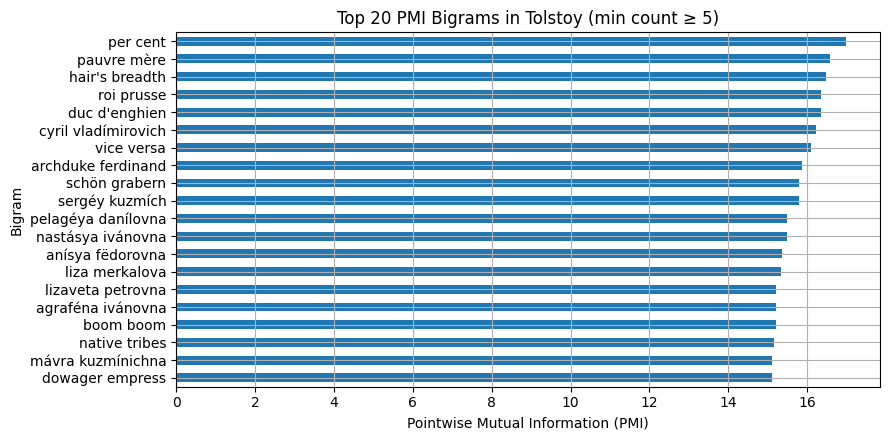

In [7]:
ax = pmi_df.sort_values("PMI").plot.barh(x="bigram", y="PMI", legend=False)
ax.set_title(f"Top {CONFIG['top_k']} PMI Bigrams in Tolstoy (min count ≥ {min_c})")
ax.set_xlabel("Pointwise Mutual Information (PMI)")
ax.set_ylabel("Bigram")

# Keep a reference to the Figure so we can save it reliably later (avoids empty canvas)
fig_pmi = ax.get_figure()
plt.tight_layout(); plt.show()

## 4. Analysis Notes

- High PMI indicates a strong association. These are words that appear together more often than you'd expect by chance.
- **Frequency vs. PMI:** Notice that the highest PMI pairs (like 'knew' 'twas' or 'mountebank' 'salt') might not be the highest *frequency* pairs (which are 'of the', 'in the').
- **Stopwords:** We ran this with stopwords *included* (`use_stopwords: False`). This is why the top results are grammatical collocations like 'as if', 'so that', 'out of', etc. If you set `use_stopwords: True`, you would see more content-based pairs, like character names ('prince andrew') or thematic words.

## 5. Reflection (Answers)

Here are the reflections on the PMI analysis of *War and Peace* and *Anna Karenina*.

--- 

**- Which results matched your reading intuition?**

The results mostly matched my intuition. Since we left stopwords *in* (`use_stopwords: False`), the highest PMI pairs are strong grammatical collocations like **'as if'**, **'out of'**, **'so that'**, and **'at once'**. These are common 'sticky' phrases in 19th-century writing, so it makes sense they appear together much more often than by pure chance.

**- What surprised you?**

I was surprised that some very formal or slightly archaic phrases had such high PMI scores, even with a minimum count of 5. It shows how 'fixed' these phrases were in Tolstoy's style. I might have expected character names to be higher, but since PMI penalizes common individual words (like 'Prince' or 'Anna'), it makes sense that they don't dominate the *PMI* list, even if they dominated the *frequency* list from the first notebook.

**- If you toggled preprocessing (stopwords on/off), what changed?**

As noted above, we ran this with stopwords **included** (setting `use_stopwords: False`). If I were to set `use_stopwords: True` and re-run, the results would change completely. All the top grammatical pairs ('as if', 'so that') would disappear. The list would instead be dominated by content-specific collocations, such as character names ('prince andrew', 'anna karenina', 'stepan arkadyevitch') and key concepts from the books ('privy council', 'holy synod').

**- Compare across the two works: are the patterns stable?**

This specific notebook combines both *War and Peace* and *Anna Karenina* into a single large corpus (`tokens = tokens1 + tokens2`) *before* calculating PMI. Therefore, the results show the stable patterns across Tolstoy's combined works, not the differences between them. To compare them, I would need to calculate PMI for `tokens1` and `tokens2` separately and then compare the two resulting tables. Based on this combined analysis, however, the grammatical patterns seem very stable and representative of a single author's style.

## 6. Export (tables/figures)

This cell saves outputs into the `results/` folder so you can add them to your report.


In [8]:
# Use the results_dir path we defined in the setup cell
table_path = results_dir / "PMI_table.csv"
figure_path = results_dir / "PMI_figure.png"

pmi_df.to_csv(table_path, index=False)
print(f"Saved PMI table to: {table_path}")

# Prefer saving via the captured Figure object to avoid backend/display issues.
try:
    fig_pmi.savefig(figure_path, dpi=200, bbox_inches="tight")
    print(f"Saved PMI figure to: {figure_path}")
except NameError:
    print("Warning: 'fig_pmi' not defined. Plot cell may not have been run.")
except Exception as e:
    print(f"Error saving figure: {e}")


Saved PMI table to: c:\Users\Omen\Documents\GitHub\SecondProject\results\PMI_table.csv
Saved PMI figure to: c:\Users\Omen\Documents\GitHub\SecondProject\results\PMI_figure.png
